In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from non_ride_detection import (
    add_first_seen_column,
    flag_maintenance_events,
    flag_id_reset_events,
    flag_temporary_disappearances,
    show_maintenance_distribution,
    analyze_maintenance_by_provider,
    check_vehicle_type_ranges,
    plot_maintenance_time_gaps
)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## Load Data

In [ ]:
df = pd.read_parquet('vehicle_events_export.parquet')
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Loaded {len(df):,} records")
print(f"Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Duration: {df['timestamp'].max() - df['timestamp'].min()}")

## Prepare Data Columns

In [ ]:
required_cols = ['timestamp', 'lat', 'lon', 'current_fuel_percent', 'change_types']
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print(f"Warning: Missing columns: {missing_cols}")
else:
    print("All required columns present")

if 'first_seen' not in df.columns:
    df = add_first_seen_column(df)

if 'disappeared' not in df.columns:
    df['disappeared'] = df['change_types'].apply(lambda x: 'last_seen' in str(x) if pd.notna(x) else False)

print(f"Disappearance events: {df['disappeared'].sum():,}")
print(f"First seen events: {df['first_seen'].sum():,}")

## Detect Maintenance Events

In [ ]:
df = flag_maintenance_events(
    df,
    time_window_minutes=30,
    distance_threshold_meters=50,
    battery_threshold=0.8,
    battery_increase=0.2,
    range_threshold=0.8,
    range_increase_meters=5000,
)
print("Maintenance detection complete")

## Distribution and Statistics

MAINTENANCE EVENT STATISTICS
Total events:        11,135,183
Maintenance events:  57,381 (0.52%)

Maintenance Event Details:
------------------------------------------------------------

Maintenance Events by Provider:
  voi_de: 12,672 (22.1%)
  dott_saarbrucken: 8,756 (15.3%)
  voi_ch: 7,033 (12.3%)
  dott_stuttgart: 3,458 (6.0%)
  dott_mannheim: 2,959 (5.2%)
  bolt_stuttgart: 2,712 (4.7%)
  dott_heilbronn: 2,503 (4.4%)
  dott_ulm: 1,690 (2.9%)
  dott_st_gallen: 1,285 (2.2%)
  dott_karlsruhe: 1,270 (2.2%)
  dott_friedrichshafen: 1,214 (2.1%)
  dott_kaiserslautern: 997 (1.7%)
  dott_ludwigsburg: 991 (1.7%)
  zeus_villingen_schwenningen: 965 (1.7%)
  dott_mainz: 899 (1.6%)
  bolt_karlsruhe: 876 (1.5%)
  dott_heidelberg: 874 (1.5%)
  dott_zurich: 806 (1.4%)
  dott_bregenz: 604 (1.1%)
  bolt_reutlingen_tuebingen: 594 (1.0%)
  zeus_ludwigsburg: 527 (0.9%)
  dott_lindau: 523 (0.9%)
  bolt_zurich: 467 (0.8%)
  dott_boblingen: 437 (0.8%)
  zeus_freiburg: 423 (0.7%)
  zeus_heidelberg: 367 (0.6

c:\Users\erike\OneDrive\Dokumente\Uni Tuebingen\ML Master\1. Semester\Data Literacy\escooter-gbfs-tracker\helper.py:395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Pick a random start time


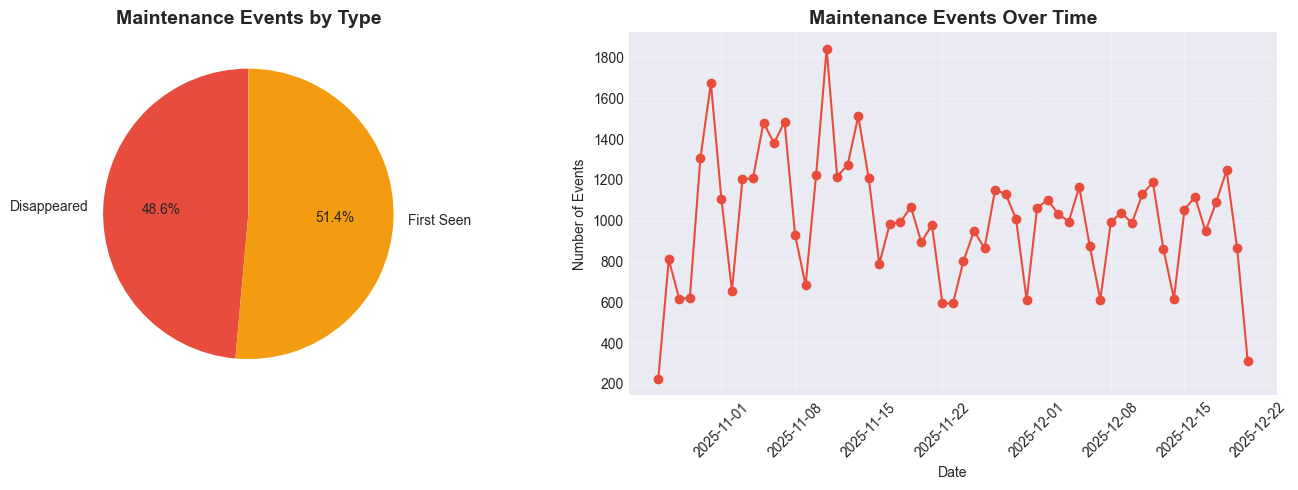

In [33]:
show_maintenance_distribution(df,   maintenance_only= True)

## Time Gap Analysis

In [ ]:
plot_maintenance_time_gaps(df, time_window_minutes=30, distance_threshold_meters=50)

In [ ]:
# Analyze maintenance patterns by provider with fleet size estimates
analysis_df = analyze_maintenance_by_provider(df, spike_window_minutes=30, use_spikes=True)

## Low Battery Disappearance Analysis

In [ ]:
disappeared_events = df[df['disappeared'] == True].copy()

print(f"Total disappearance events: {len(disappeared_events):,}")
print(f"  - With battery data: {disappeared_events['current_fuel_percent'].notna().sum():,}")
print(f"  - With range data: {disappeared_events['current_range_meters'].notna().sum():,}")

has_battery = disappeared_events['current_fuel_percent'].notna()
has_range_only = disappeared_events['current_fuel_percent'].isna() & disappeared_events['current_range_meters'].notna()

print(f"\n--- Battery-based providers ---")
battery_disappearances = disappeared_events[has_battery]['current_fuel_percent']
print(f"Count: {len(battery_disappearances):,}")
print(f"Min: {battery_disappearances.min():.2%}")
print(f"5th percentile: {battery_disappearances.quantile(0.05):.2%}")
print(f"10th percentile: {battery_disappearances.quantile(0.10):.2%}")
print(f"25th percentile: {battery_disappearances.quantile(0.25):.2%}")
print(f"Median: {battery_disappearances.median():.2%}")
print(f"Mean: {battery_disappearances.mean():.2%}")

print(f"\n--- Range-only providers ---")
range_disappearances = disappeared_events[has_range_only]['current_range_meters']
print(f"Count: {len(range_disappearances):,}")
if len(range_disappearances) > 0:
    print(f"Min: {range_disappearances.min():.0f}m")
    print(f"5th percentile: {range_disappearances.quantile(0.05):.0f}m")
    print(f"10th percentile: {range_disappearances.quantile(0.10):.0f}m")
    print(f"25th percentile: {range_disappearances.quantile(0.25):.0f}m")
    print(f"Median: {range_disappearances.median():.0f}m")

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
battery_disappearances.hist(bins=50, ax=ax1, color='#e74c3c', edgecolor='black', alpha=0.7)
ax1.axvline(0.10, color='blue', linestyle='--', linewidth=2, label='10% threshold')
ax1.axvline(0.15, color='green', linestyle='--', linewidth=2, label='15% threshold')
ax1.set_title('Battery Level at Disappearance (All Providers)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Battery Percentage')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
low_battery = battery_disappearances[battery_disappearances <= 0.30]
low_battery.hist(bins=30, ax=ax2, color='#e74c3c', edgecolor='black', alpha=0.7)
ax2.axvline(0.10, color='blue', linestyle='--', linewidth=2, label='10% threshold')
ax2.axvline(0.15, color='green', linestyle='--', linewidth=2, label='15% threshold')
ax2.set_title(f'Low Battery Disappearances (<=30%) - {len(low_battery):,} events', fontsize=12, fontweight='bold')
ax2.set_xlabel('Battery Percentage')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
provider_min_battery = disappeared_events[has_battery].groupby('provider')['current_fuel_percent'].min().sort_values()
provider_min_battery.head(20).plot(kind='barh', ax=ax3, color='#3498db')
ax3.set_title('Minimum Battery at Disappearance (by Provider)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Minimum Battery %')
ax3.axvline(0.10, color='red', linestyle='--', linewidth=2)
ax3.grid(True, alpha=0.3, axis='x')

ax4 = axes[1, 1]
low_battery_by_provider = disappeared_events[has_battery & (disappeared_events['current_fuel_percent'] <= 0.10)].groupby('provider').size().sort_values(ascending=False)
if len(low_battery_by_provider) > 0:
    low_battery_by_provider.head(15).plot(kind='barh', ax=ax4, color='#e74c3c')
    ax4.set_title('Disappearances with Battery <=10% (by Provider)', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Count')
    ax4.grid(True, alpha=0.3, axis='x')
else:
    ax4.text(0.5, 0.5, 'No disappearances with battery <=10%', ha='center', va='center', fontsize=12)
    ax4.set_title('Disappearances with Battery <=10%', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nLOW BATTERY DISAPPEARANCE SUMMARY")
print("=" * 60)
for threshold in [0.05, 0.10, 0.15, 0.20]:
    count = (battery_disappearances <= threshold).sum()
    pct = count / len(battery_disappearances) * 100
    print(f"Battery <= {threshold:.0%}: {count:,} events ({pct:.2f}% of disappearances)")

In [ ]:
range_only_disappearances = disappeared_events[has_range_only].copy()

if len(range_only_disappearances) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1 = axes[0]
    range_values = range_only_disappearances['current_range_meters'] / 1000
    range_values.hist(bins=50, ax=ax1, color='#9b59b6', edgecolor='black', alpha=0.7)
    ax1.axvline(2, color='red', linestyle='--', linewidth=2, label='2km threshold')
    ax1.axvline(5, color='orange', linestyle='--', linewidth=2, label='5km threshold')
    ax1.set_title('Range at Disappearance (Range-only Providers)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Range (km)')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[1]
    low_range_by_provider = range_only_disappearances[range_only_disappearances['current_range_meters'] <= 5000].groupby('provider').size().sort_values(ascending=False)
    if len(low_range_by_provider) > 0:
        low_range_by_provider.head(15).plot(kind='barh', ax=ax2, color='#9b59b6')
        ax2.set_title('Disappearances with Range <=5km (by Provider)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Count')
        ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print("\nLOW RANGE DISAPPEARANCE SUMMARY (Range-only providers)")
    print("=" * 60)
    range_meters = range_only_disappearances['current_range_meters']
    for threshold in [1000, 2000, 3000, 5000]:
        count = (range_meters <= threshold).sum()
        pct = count / len(range_meters) * 100
        print(f"Range <= {threshold/1000:.0f}km: {count:,} events ({pct:.2f}% of disappearances)")

In [ ]:
# Filter out maintenance and ID reset events for clean comparison
d_clean = disappeared_events[
    (disappeared_events.get('is_maintenance', False) == False) & 
    (disappeared_events.get('is_id_reset', False) == False)
].copy()

first_seen_events = df[df['first_seen'] == True].copy()
fs_clean = first_seen_events[
    (first_seen_events.get('is_maintenance', False) == False) & 
    (first_seen_events.get('is_id_reset', False) == False)
].copy()

print(f"Filtered out {len(disappeared_events) - len(d_clean):,} maintenance/ID-reset disappearances")
print(f"Filtered out {len(first_seen_events) - len(fs_clean):,} maintenance/ID-reset first_seen events")

print("\n=== FIRST SEEN vs DISAPPEARED COMPARISON (cleaned) ===\n")

fs_battery = fs_clean[fs_clean['current_fuel_percent'].notna()]['current_fuel_percent']
d_battery = d_clean[d_clean['current_fuel_percent'].notna()]['current_fuel_percent']

print(f"{'Metric':<25} {'First Seen':>15} {'Disappeared':>15}")
print("-" * 55)
print(f"{'Count':<25} {len(fs_battery):>15,} {len(d_battery):>15,}")
print(f"{'Min':<25} {fs_battery.min():>15.2%} {d_battery.min():>15.2%}")
print(f"{'5th percentile':<25} {fs_battery.quantile(0.05):>15.2%} {d_battery.quantile(0.05):>15.2%}")
print(f"{'10th percentile':<25} {fs_battery.quantile(0.10):>15.2%} {d_battery.quantile(0.10):>15.2%}")
print(f"{'Median':<25} {fs_battery.median():>15.2%} {d_battery.median():>15.2%}")

print("\n=== LOW BATTERY COMPARISON ===\n")
print(f"{'Threshold':<15} {'First Seen':>15} {'Disappeared':>15} {'Ratio (FS/D)':>15}")
print("-" * 60)
for threshold in [0.05, 0.10, 0.15, 0.20]:
    fs_count = (fs_battery <= threshold).sum()
    d_count = (d_battery <= threshold).sum()
    ratio = fs_count / d_count if d_count > 0 else 0
    print(f"<= {threshold:.0%}{'':<10} {fs_count:>15,} {d_count:>15,} {ratio:>15.2f}")

print("\n" + "=" * 60)
if (fs_battery <= 0.10).sum() >= (d_battery <= 0.10).sum() * 0.5:
    print("CONCLUSION: Low-battery scooters ARE still being ridden.")
    print("           No need for low-battery shutdown detection.")
else:
    print("CONCLUSION: Significantly fewer first_seen at low battery.")
    print("           Low-battery shutdown detection may be useful.")

In [ ]:
# Track what happens to scooters that disappear with low battery
LOW_BATTERY_THRESHOLD = 0.15
RECOVERY_BATTERY_THRESHOLD = 0.50

low_battery_disappeared = d_clean[
    (d_clean['current_fuel_percent'].notna()) & 
    (d_clean['current_fuel_percent'] <= LOW_BATTERY_THRESHOLD)
][['vehicle_id', 'provider', 'timestamp', 'current_fuel_percent']].copy()
low_battery_disappeared = low_battery_disappeared.rename(columns={
    'timestamp': 'disappear_time', 
    'current_fuel_percent': 'disappear_battery'
})

print(f"Low battery disappearances (<={LOW_BATTERY_THRESHOLD:.0%}): {len(low_battery_disappeared):,}")

all_events = df[['vehicle_id', 'provider', 'timestamp', 'current_fuel_percent']].copy()

results = []
for provider in tqdm(low_battery_disappeared['provider'].unique(), desc="Providers"):
    prov_disappeared = low_battery_disappeared[low_battery_disappeared['provider'] == provider]
    prov_events = all_events[all_events['provider'] == provider].sort_values('timestamp')
    vehicle_groups = prov_events.groupby('vehicle_id')
    
    for _, row in prov_disappeared.iterrows():
        vid = row['vehicle_id']
        d_time = row['disappear_time']
        d_batt = row['disappear_battery']
        
        if vid in vehicle_groups.groups:
            vehicle_events = vehicle_groups.get_group(vid)
            later = vehicle_events[vehicle_events['timestamp'] > d_time]
            
            if len(later) > 0:
                max_batt = later['current_fuel_percent'].max()
                first_time = later['timestamp'].min()
                gap_hrs = (first_time - d_time).total_seconds() / 3600
                results.append({
                    'recovered': max_batt >= RECOVERY_BATTERY_THRESHOLD if pd.notna(max_batt) else False,
                    'reappeared': True,
                    'time_gap_hours': gap_hrs
                })
            else:
                results.append({'recovered': False, 'reappeared': False, 'time_gap_hours': None})
        else:
            results.append({'recovered': False, 'reappeared': False, 'time_gap_hours': None})

results_df = pd.DataFrame(results)

print(f"\nLOW BATTERY DISAPPEARANCE RECOVERY ANALYSIS")
print(f"{'='*60}")
print(f"Total analyzed: {len(results_df):,}")

reappeared = results_df[results_df['reappeared'] == True]
recovered = results_df[results_df['recovered'] == True]
never_seen = results_df[results_df['reappeared'] == False]

print(f"\nReappeared later (any battery): {len(reappeared):,} ({len(reappeared)/len(results_df)*100:.1f}%)")
print(f"Recovered (>{RECOVERY_BATTERY_THRESHOLD:.0%} battery): {len(recovered):,} ({len(recovered)/len(results_df)*100:.1f}%)")
print(f"Never seen again: {len(never_seen):,} ({len(never_seen)/len(results_df)*100:.1f}%)")

if len(recovered) > 0:
    print(f"\nMedian recovery time: {recovered['time_gap_hours'].median():.1f} hours")

In [ ]:
# Recalibrate range: use max range seen within 60min window to correct for delayed updates
df_sorted = df.sort_values(['vehicle_id', 'timestamp']).copy()

max_range_lookup = {}
for vid, group in tqdm(df_sorted.groupby('vehicle_id'), desc="Computing recalibrated range"):
    group = group.sort_values('timestamp')
    times = group['timestamp'].values
    ranges = group['current_range_meters'].values
    indices = group.index.values
    
    for i in range(len(group)):
        mask = (times > times[i]) & (times <= times[i] + np.timedelta64(60, 'm'))
        if mask.any():
            max_range_lookup[indices[i]] = max(ranges[i], ranges[mask].max())
        else:
            max_range_lookup[indices[i]] = ranges[i]

df['recalibrated_current_range_meters'] = df.index.map(max_range_lookup)

print("Original vs Recalibrated range:")
print(df[['current_range_meters', 'recalibrated_current_range_meters']].describe())

df.to_parquet('vehicle_events_export.parquet')

In [ ]:
# Flag temporary disappearances (all except the last disappearance per vehicle)
df = flag_temporary_disappearances(df)
df.to_parquet('vehicle_events_export.parquet')